In [84]:
import statsmodels.api as sm
from itertools import product
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import copy
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, silhouette_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from joblib import Parallel, delayed

from sklearn import svm

# Предобработка данных

In [34]:
data = pd.read_csv('Downloads/QUD-dataset-master/QUD-dataset-master/QUD_app-1 (desktop).csv')

In [35]:
data.rename(columns={'Micro-moments': 'labels'}, inplace=True)
#data.rename(columns={'Normalized power': 'value'}, inplace=True)

In [4]:
for i in range(46930):
    if data.loc[i, 'labels'] == 1 or data.loc[i, 'labels'] == 2:
        data.loc[i, 'labels'] = 0
    elif data.loc[i, 'labels'] == 3 or data.loc[i, 'labels'] == 4:
        data.loc[i, 'labels'] = 1

In [36]:
data

,qdate,time,appID,occupancy,Power consumption,Normalized power,Quantized power,labels
0,3/3/2019,13:19:06,app_1,1,0.00,-0.002259,0.00,0
1,3/3/2019,13:19:10,app_1,1,0.00,-0.002259,-166.43,1
2,3/3/2019,13:19:13,app_1,1,166.43,0.007632,0.00,3
3,3/3/2019,13:19:17,app_1,1,159.55,0.007223,0.00,3
4,3/3/2019,13:19:21,app_1,1,143.27,0.006255,0.00,3
...,...,...,...,...,...,...,...,...
46925,5/27/2019,10:06:55,app_1,1,-1.64,-0.002357,0.00,0
46926,5/27/2019,12:15:47,app_1,1,-10.64,-0.002891,0.00,0
46927,5/27/2019,13:07:07,app_1,1,79.22,0.002449,0.00,0
46928,5/27/2019,14:06:57,app_1,1,74.38,0.002161,0.00,0


In [6]:
arima_data = data[:30000]
svm_data = data[10000:40000]
test_data = data[40000:]
print(arima_data.shape[0], svm_data.shape[0], test_data.shape[0])

30000 30000 6930


In [7]:
norm_data = arima_data[arima_data.labels==0]
anom_data = arima_data[arima_data.labels==1]

In [8]:
norm_data

,qdate,time,appID,occupancy,Power consumption,Normalized power,Quantized power,labels
0,3/3/2019,13:19:06,app_1,1,0.0,-0.002259,0.00,0
1,3/3/2019,13:19:10,app_1,1,0.0,-0.002259,-166.43,0
30,3/3/2019,13:21:06,app_1,1,0.0,-0.002259,0.00,0
31,3/3/2019,13:21:10,app_1,1,0.0,-0.002259,-141.80,0
60,3/3/2019,13:23:38,app_1,1,0.0,-0.002259,0.00,0
...,...,...,...,...,...,...,...,...
29911,3/8/2019,14:22:18,app_1,0,0.0,-0.002259,-17.85,0
29940,3/8/2019,14:35:22,app_1,0,0.0,-0.002259,0.00,0
29941,3/8/2019,14:35:29,app_1,0,0.0,-0.002259,-16.71,0
29970,3/8/2019,14:46:00,app_1,0,0.0,-0.002259,0.00,0


In [9]:
anom_data

,qdate,time,appID,occupancy,Power consumption,Normalized power,Quantized power,labels
2,3/3/2019,13:19:13,app_1,1,166.43,0.007632,0.00,1
3,3/3/2019,13:19:17,app_1,1,159.55,0.007223,0.00,1
4,3/3/2019,13:19:21,app_1,1,143.27,0.006255,0.00,1
5,3/3/2019,13:19:24,app_1,1,175.88,0.008193,0.00,1
6,3/3/2019,13:19:28,app_1,1,176.66,0.008240,0.00,1
...,...,...,...,...,...,...,...,...
29995,3/8/2019,15:10:45,app_1,0,15.83,-0.001318,0.00,1
29996,3/8/2019,15:10:53,app_1,0,17.37,-0.001227,0.00,1
29997,3/8/2019,15:11:00,app_1,0,16.27,-0.001292,0.00,1
29998,3/8/2019,15:11:07,app_1,0,15.70,-0.001326,0.00,1


In [119]:
hours = []
curr_minut = 0

str = data.qdate[0]
date = str.split('/')

str = data.time[0]
time = str.split(':')

zero = datetime(year=int(date[2]), month=int(date[0]), day=int(date[1]), hour=int(time[0]), minute=int(time[1]), second=int(time[2]), microsecond=0, tzinfo=None)

curr_t = '13'
curr_elem = data.loc[0, 'time':]
#curr_elem['time'] = int(curr_t)
#hours.append(curr_elem)
col = 1
for i in range(1, 46930):
    str = data.time[i]
    time = str.split(':')
    #print(time[0], curr_t, time[0] == curr_t)
    if time[0] == curr_t:
        col += 1
        curr_elem += data.loc[i, 'time':]
    else:
        curr_elem['occupancy'] /= col
        curr_elem['Power consumption'] /= col
        curr_elem['Normalized power'] /= col
        curr_elem['Quantized power'] /= col
        if curr_elem['labels'] / col < 0.5:
            curr_elem['labels'] = 0
        elif curr_elem['labels'] / col < 1.5:
            curr_elem['labels'] = 1
        elif curr_elem['labels'] / col < 2.5:
            curr_elem['labels'] = 2
        elif curr_elem['labels'] / col < 3.5:
            curr_elem['labels'] = 3
        else:
            curr_elem['labels'] = 4
        curr_elem['time'] = int(curr_t)
        curr_elem['appID'] = 1
        hours.append(np.array(curr_elem))
        col = 1
        curr_t = time[0]
        curr_elem = data.loc[i, 'time':]

In [120]:
hours = np.array(hours)
len(hours)

573

In [39]:
hours[:, 6]

array([2, 2, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 3, 3, 2, 3, 3,
       3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 2, 2, 3, 2, 4,
       3, 3, 3, 4, 2, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 0, 2, 1, 1,
       3, 3, 1, 3, 3, 3, 3, 2, 3, 4, 2, 3, 3, 3, 3, 4, 3, 4, 4, 3, 0, 0,
       3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 2, 4, 2, 4, 3, 3, 4, 3,
       0, 0, 3, 0, 2, 3, 3, 2, 1, 4, 4, 4, 2, 4, 2, 2, 3, 4, 4, 1, 4, 3,
       3, 4, 0, 0, 0, 3, 2, 0, 3, 3, 3, 3, 2, 0, 4, 4, 4, 4, 2, 4, 2, 2,
       3, 4, 3, 3, 0, 1, 2, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 4, 1, 3,
       2, 4, 3, 4, 3, 4, 0, 0, 2, 2, 0, 1, 3, 3, 2, 3, 2, 2, 4, 4, 3, 3,
       3, 2, 4, 2, 2, 3, 3, 3, 0, 0, 0, 4, 1, 0, 2, 3, 2, 3, 2, 2, 2, 4,
       4, 4, 2, 4, 3, 2, 3, 3, 4, 3, 0, 0, 0, 4, 1, 0, 1, 2, 2, 3, 2, 3,
       1, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 2, 1, 0, 0, 3, 4, 4, 4, 4, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 1, 2, 3, 4, 1, 0, 3, 0, 3, 3, 0, 1, 0, 0,

# Обучение ARIMA на нормальных данных

In [10]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
preprocessed_data = differencing(norm_data, 'Normalized power', 1)
preprocessed_data = np.array(preprocessed_data)
preprocessed_data

array([6.2580212e-22, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00])

In [46]:
norm = hours[:24]
X = norm[:, 3]
y = norm[:, 6]
y

array([2, 2, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 3, 3, 2, 3, 3,
       3, 3], dtype=object)

In [52]:
X = X.astype(float)

In [24]:
# order=(2, 1, 2) - 0.48

In [53]:
arma = ARIMA(X, order=(4, 0, 4), enforce_stationarity = False, enforce_invertibility = False) # (4, 0, 4)
arma_fit = arma.fit()

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
horizon = 100

In [63]:
y_pred = arma_fit.forecast(1)#(svm_data.shape[0])

In [64]:
predict = np.array(y_pred)
predict

array([-77.80876726])

In [61]:
norm.shape, svm_data.shape, svm_data['Normalized power'].shape

((7624,), (30000, 8), (30000,))

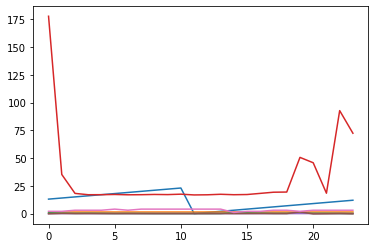

In [56]:
import matplotlib.pyplot as plt
plt.plot(norm)

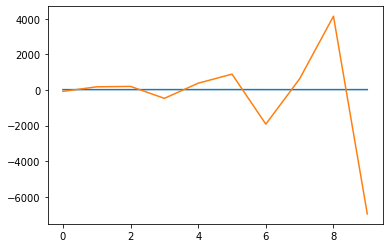

In [62]:
plt.plot(svm_data['Power consumption'][:10].values)
plt.plot(predict)

In [81]:
# predict - предсказала ARIMA на 1 час
true = hours[25]
#print(true)
X_true = true[3]
y_true = true[6]
X_true = np.expand_dims(X_true, axis=0)
X_true = np.expand_dims(X_true, axis=1)
predict = np.expand_dims(predict, axis=1)

In [67]:
clf = svm.SVC()
clf.fit(np.expand_dims(X, axis=1), y.astype(int))

SVC()

In [82]:
P_real = clf.predict(X_true)
P_pred = clf.predict(predict)

In [86]:

if (P_real == P_pred):
    if P_pred == 0 or P_pred == 1 or P_pred == 2:
        ans.append(0)
    else:
        ans.append(1)
else:
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(np.expand_dims(X, axis=1), y.astype(int))
    P_knn = knn.predict(X_true)
    #P_pred = knn.predict(predict)
    if P_knn == P_real:
        if P_knn == 3 or P_knn == 4:
            ans.appens(1)
        else:
            loss = log_loss(P_real, P_pred)
            print('LOSS: ', loss)
            if loss < 0.2:
                ans.appens(0)
            else:
                ans.append(1)
    else:
        if P_knn == 3 or P_knn == 4:
            ans.appens(1)
        else:
            loss = log_loss(P_real, P_knn)
            print('LOSS: ', loss)
            if loss < 0.2:
                ans.appens(0)
            else:
                ans.append(1)
            

In [147]:
ans = []
for i in range(hours.shape[0] - 25):
    print('>>>>>>>>>>>>>>>>>>>>>>>>', i)
    norm = hours[i:i + 24]
    X = norm[:, 3]
    y = norm[:, 6]
    X = X.astype(float)
    
    arma = ARIMA(X, order=(4, 0, 4), enforce_stationarity = False, enforce_invertibility = False) # (4, 0, 4)
    arma_fit = arma.fit()
    y_pred = arma_fit.forecast(1)
    predict = np.array(y_pred)
    
    true = hours[i + 25]
    X_true = true[3]
    y_true = true[6]
    X_true = np.expand_dims(X_true, axis=0)
    X_true = np.expand_dims(X_true, axis=1)
    predict = np.expand_dims(predict, axis=1)
    
    clf = svm.SVC()
    clf.fit(np.expand_dims(X, axis=1), y.astype(int))
    
    P_real = clf.predict(X_true)
    P_pred = clf.predict(predict)
    
    if (P_real == P_pred):
        if P_pred == 0 or P_pred == 1 or P_pred == 2:
            ans.append(0)
        else:
            ans.append(1)
    else:
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(np.expand_dims(X, axis=1), y.astype(int))
        print(y)
        P_knn = knn.predict(X_true)
        if P_knn == P_real:
            if P_knn == 3 or P_knn == 4:
                ans.append(1)
            else:
                print('SVM: ', P_real, P_pred)
                loss = P_real * np.log(P_pred + 1e-5)
                print('LOSS: ', loss)
                if loss < 2:
                    ans.append(0)
                else:
                    ans.append(1)
        else:
            if P_knn == 3 or P_knn == 4:
                ans.append(1)
            else:
                print('KNN: ', P_real, P_knn)
                loss = P_real * np.log(P_knn + 1e-5)
                print('LOSS: ', loss)
                if loss < 2:
                    ans.append(0)
                else:
                    ans.append(1)
            

>>>>>>>>>>>>>>>>>>>>>>>> 0
>>>>>>>>>>>>>>>>>>>>>>>> 1


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 2
[3 3 3 4 3 4 4 4 4 4 4 4 1 2 2 3 3 2 3 3 3 3 3 4]
>>>>>>>>>>>>>>>>>>>>>>>> 3


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 4 3 4 4 4 4 4 4 4 1 2 2 3 3 2 3 3 3 3 3 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 4
[3 4 3 4 4 4 4 4 4 4 1 2 2 3 3 2 3 3 3 3 3 4 4 3]
>>>>>>>>>>>>>>>>>>>>>>>> 5


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 6
>>>>>>>>>>>>>>>>>>>>>>>> 7


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 8
>>>>>>>>>>>>>>>>>>>>>>>> 9


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 10
>>>>>>>>>>>>>>>>>>>>>>>> 11


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 12
>>>>>>>>>>>>>>>>>>>>>>>> 13


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 14
>>>>>>>>>>>>>>>>>>>>>>>> 15


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 16
>>>>>>>>>>>>>>>>>>>>>>>> 17


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 18
>>>>>>>>>>>>>>>>>>>>>>>> 19


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 20
[3 3 3 3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 0 2 2 3 2 4]
>>>>>>>>>>>>>>>>>>>>>>>> 21


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 0 2 2 3 2 4 3]
>>>>>>>>>>>>>>>>>>>>>>>> 22
[3 3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 0 2 2 3 2 4 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 23


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 0 2 2 3 2 4 3 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 24
[3 4 4 3 4 4 4 4 4 4 4 4 4 4 0 2 2 3 2 4 3 3 3 4]
>>>>>>>>>>>>>>>>>>>>>>>> 25


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 26
>>>>>>>>>>>>>>>>>>>>>>>> 27


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 28
>>>>>>>>>>>>>>>>>>>>>>>> 29


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 4 4 4 4 4 4 4 4 0 2 2 3 2 4 3 3 3 4 2 3 3 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 30
>>>>>>>>>>>>>>>>>>>>>>>> 31


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 4 4 4 4 4 4 0 2 2 3 2 4 3 3 3 4 2 3 3 3 3 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 32
>>>>>>>>>>>>>>>>>>>>>>>> 33


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 34
>>>>>>>>>>>>>>>>>>>>>>>> 35


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 4 4 0 2 2 3 2 4 3 3 3 4 2 3 3 3 3 4 4 3 4 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 36
>>>>>>>>>>>>>>>>>>>>>>>> 37


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 38
>>>>>>>>>>>>>>>>>>>>>>>> 39


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 40
[2 3 2 4 3 3 3 4 2 3 3 3 3 4 4 3 4 4 4 3 4 3 0 2]
>>>>>>>>>>>>>>>>>>>>>>>> 41


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 42
>>>>>>>>>>>>>>>>>>>>>>>> 43


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 44
>>>>>>>>>>>>>>>>>>>>>>>> 45


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 46
>>>>>>>>>>>>>>>>>>>>>>>> 47


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 48
>>>>>>>>>>>>>>>>>>>>>>>> 49


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 50
>>>>>>>>>>>>>>>>>>>>>>>> 51


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 52
>>>>>>>>>>>>>>>>>>>>>>>> 53


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 54
>>>>>>>>>>>>>>>>>>>>>>>> 55


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 56
>>>>>>>>>>>>>>>>>>>>>>>> 57


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 58
>>>>>>>>>>>>>>>>>>>>>>>> 59


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 60
>>>>>>>>>>>>>>>>>>>>>>>> 61


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 62
>>>>>>>>>>>>>>>>>>>>>>>> 63


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 64
>>>>>>>>>>>>>>>>>>>>>>>> 65


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 66
>>>>>>>>>>>>>>>>>>>>>>>> 67


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 68
>>>>>>>>>>>>>>>>>>>>>>>> 69


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 70
>>>>>>>>>>>>>>>>>>>>>>>> 71


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 72
>>>>>>>>>>>>>>>>>>>>>>>> 73


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 74
>>>>>>>>>>>>>>>>>>>>>>>> 75


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 76
>>>>>>>>>>>>>>>>>>>>>>>> 77


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 78
>>>>>>>>>>>>>>>>>>>>>>>> 79


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 80
>>>>>>>>>>>>>>>>>>>>>>>> 81


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 82
[3 4 4 3 0 0 3 0 3 3 3 2 3 3 3 3 3 2 3 4 2 4 2 4]
KNN:  [4] [2]
LOSS:  [2.77260872]
>>>>>>>>>>>>>>>>>>>>>>>> 83


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 4 3 0 0 3 0 3 3 3 2 3 3 3 3 3 2 3 4 2 4 2 4 3]
>>>>>>>>>>>>>>>>>>>>>>>> 84
>>>>>>>>>>>>>>>>>>>>>>>> 85


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 0 0 3 0 3 3 3 2 3 3 3 3 3 2 3 4 2 4 2 4 3 3 4]
>>>>>>>>>>>>>>>>>>>>>>>> 86
>>>>>>>>>>>>>>>>>>>>>>>> 87


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 88
>>>>>>>>>>>>>>>>>>>>>>>> 89


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 90
>>>>>>>>>>>>>>>>>>>>>>>> 91


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 92
>>>>>>>>>>>>>>>>>>>>>>>> 93


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 94
>>>>>>>>>>>>>>>>>>>>>>>> 95


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 96
>>>>>>>>>>>>>>>>>>>>>>>> 97


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 98
>>>>>>>>>>>>>>>>>>>>>>>> 99


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 100
>>>>>>>>>>>>>>>>>>>>>>>> 101


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 102
[2 4 2 4 3 3 4 3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2]
SVM:  [2] [4]
LOSS:  [2.77259372]
>>>>>>>>>>>>>>>>>>>>>>>> 103
[4 2 4 3 3 4 3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3]
SVM:  [2] [3]
LOSS:  [2.19723124]
>>>>>>>>>>>>>>>>>>>>>>>> 104
>>>>>>>>>>>>>>>>>>>>>>>> 105


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 106
[3 3 4 3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3 4 4 1]
>>>>>>>>>>>>>>>>>>>>>>>> 107
[3 4 3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3 4 4 1 4]
KNN:  [3] [0]
LOSS:  [-34.53877639]
>>>>>>>>>>>>>>>>>>>>>>>> 108
[4 3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3 4 4 1 4 3]
KNN:  [3] [2]
LOSS:  [2.07945654]
>>>>>>>>>>>>>>>>>>>>>>>> 109


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3 4 4 1 4 3 3]
SVM:  [0] [4]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 110
>>>>>>>>>>>>>>>>>>>>>>>> 111


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3 4 4 1 4 3 3 4 0]
>>>>>>>>>>>>>>>>>>>>>>>> 112
>>>>>>>>>>>>>>>>>>>>>>>> 113


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 114
>>>>>>>>>>>>>>>>>>>>>>>> 115


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 116
>>>>>>>>>>>>>>>>>>>>>>>> 117


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 118
>>>>>>>>>>>>>>>>>>>>>>>> 119


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 120
>>>>>>>>>>>>>>>>>>>>>>>> 121


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 122
>>>>>>>>>>>>>>>>>>>>>>>> 123
>>>>>>>>>>>>>>>>>>>>>>>> 124


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 125
>>>>>>>>>>>>>>>>>>>>>>>> 126
>>>>>>>>>>>>>>>>>>>>>>>> 127
>>>>>>>>>>>>>>>>>>>>>>>> 128


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 129
>>>>>>>>>>>>>>>>>>>>>>>> 130


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 3 3 4 0 0 0 3 2 0 3 3 3 3 2 0 4 4 4 4 2 4 2 2]
>>>>>>>>>>>>>>>>>>>>>>>> 131
>>>>>>>>>>>>>>>>>>>>>>>> 132


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 4 0 0 0 3 2 0 3 3 3 3 2 0 4 4 4 4 2 4 2 2 3 4]
>>>>>>>>>>>>>>>>>>>>>>>> 133
>>>>>>>>>>>>>>>>>>>>>>>> 134
>>>>>>>>>>>>>>>>>>>>>>>> 135
[0 0 3 2 0 3 3 3 3 2 0 4 4 4 4 2 4 2 2 3 4 3 3 0]
KNN:  [4] [0]
LOSS:  [-46.05170186]
>>>>>>>>>>>>>>>>>>>>>>>> 136


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 3 2 0 3 3 3 3 2 0 4 4 4 4 2 4 2 2 3 4 3 3 0 1]
KNN:  [4] [2]
LOSS:  [2.77260872]
>>>>>>>>>>>>>>>>>>>>>>>> 137
[3 2 0 3 3 3 3 2 0 4 4 4 4 2 4 2 2 3 4 3 3 0 1 2]
>>>>>>>>>>>>>>>>>>>>>>>> 138


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 139
>>>>>>>>>>>>>>>>>>>>>>>> 140


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 141
>>>>>>>>>>>>>>>>>>>>>>>> 142


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 143
>>>>>>>>>>>>>>>>>>>>>>>> 144


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2 0 4 4 4 4 2 4 2 2 3 4 3 3 0 1 2 0 2 3 3 2 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 145
[0 4 4 4 4 2 4 2 2 3 4 3 3 0 1 2 0 2 3 3 2 3 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 146


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 147
>>>>>>>>>>>>>>>>>>>>>>>> 148


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 149
>>>>>>>>>>>>>>>>>>>>>>>> 150


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 151
>>>>>>>>>>>>>>>>>>>>>>>> 152


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 153
>>>>>>>>>>>>>>>>>>>>>>>> 154


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 155
>>>>>>>>>>>>>>>>>>>>>>>> 156


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 157
>>>>>>>>>>>>>>>>>>>>>>>> 158


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 159
>>>>>>>>>>>>>>>>>>>>>>>> 160


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 161
>>>>>>>>>>>>>>>>>>>>>>>> 162


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 163
>>>>>>>>>>>>>>>>>>>>>>>> 164


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 165
>>>>>>>>>>>>>>>>>>>>>>>> 166


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 167
>>>>>>>>>>>>>>>>>>>>>>>> 168


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 169
[3 2 2 3 4 1 3 2 4 3 4 3 4 0 0 2 2 0 1 3 3 2 3 2]
SVM:  [2] [3]
LOSS:  [2.19723124]
>>>>>>>>>>>>>>>>>>>>>>>> 170


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2 2 3 4 1 3 2 4 3 4 3 4 0 0 2 2 0 1 3 3 2 3 2 2]
SVM:  [2] [3]
LOSS:  [2.19723124]
>>>>>>>>>>>>>>>>>>>>>>>> 171
[2 3 4 1 3 2 4 3 4 3 4 0 0 2 2 0 1 3 3 2 3 2 2 4]
SVM:  [2] [3]
LOSS:  [2.19723124]
>>>>>>>>>>>>>>>>>>>>>>>> 172


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 4 1 3 2 4 3 4 3 4 0 0 2 2 0 1 3 3 2 3 2 2 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 173
[4 1 3 2 4 3 4 3 4 0 0 2 2 0 1 3 3 2 3 2 2 4 4 3]
>>>>>>>>>>>>>>>>>>>>>>>> 174


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 175
>>>>>>>>>>>>>>>>>>>>>>>> 176


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 177
>>>>>>>>>>>>>>>>>>>>>>>> 178


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 179
>>>>>>>>>>>>>>>>>>>>>>>> 180


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 181
>>>>>>>>>>>>>>>>>>>>>>>> 182


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 183
>>>>>>>>>>>>>>>>>>>>>>>> 184


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 185
>>>>>>>>>>>>>>>>>>>>>>>> 186


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 187
>>>>>>>>>>>>>>>>>>>>>>>> 188


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 189
>>>>>>>>>>>>>>>>>>>>>>>> 190


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 191
>>>>>>>>>>>>>>>>>>>>>>>> 192


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 193
>>>>>>>>>>>>>>>>>>>>>>>> 194


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 195
>>>>>>>>>>>>>>>>>>>>>>>> 196


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 197
>>>>>>>>>>>>>>>>>>>>>>>> 198


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 2 4 2 2 3 3 3 0 0 0 4 1 0 2 3 2 3 2 2 2 4 4 4]
SVM:  [2] [4]
LOSS:  [2.77259372]
>>>>>>>>>>>>>>>>>>>>>>>> 199
>>>>>>>>>>>>>>>>>>>>>>>> 200


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 201
>>>>>>>>>>>>>>>>>>>>>>>> 202


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 203
>>>>>>>>>>>>>>>>>>>>>>>> 204


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 0 0 0 4 1 0 2 3 2 3 2 2 2 4 4 4 2 4 3 2 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 205
[3 0 0 0 4 1 0 2 3 2 3 2 2 2 4 4 4 2 4 3 2 3 3 4]
>>>>>>>>>>>>>>>>>>>>>>>> 206


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 4 1 0 2 3 2 3 2 2 2 4 4 4 2 4 3 2 3 3 4 3]
>>>>>>>>>>>>>>>>>>>>>>>> 207
[0 0 4 1 0 2 3 2 3 2 2 2 4 4 4 2 4 3 2 3 3 4 3 0]
>>>>>>>>>>>>>>>>>>>>>>>> 208


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 209
>>>>>>>>>>>>>>>>>>>>>>>> 210


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 211
>>>>>>>>>>>>>>>>>>>>>>>> 212


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 213
>>>>>>>>>>>>>>>>>>>>>>>> 214


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 215
>>>>>>>>>>>>>>>>>>>>>>>> 216


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 217
[2 2 4 4 4 2 4 3 2 3 3 4 3 0 0 0 4 1 0 1 2 2 3 2]
KNN:  [4] [1]
LOSS:  [3.99998e-05]
>>>>>>>>>>>>>>>>>>>>>>>> 218


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 219
[4 4 4 2 4 3 2 3 3 4 3 0 0 0 4 1 0 1 2 2 3 2 3 1]
SVM:  [2] [3]
LOSS:  [2.19723124]
>>>>>>>>>>>>>>>>>>>>>>>> 220


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 221
>>>>>>>>>>>>>>>>>>>>>>>> 222


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 223
[4 3 2 3 3 4 3 0 0 0 4 1 0 1 2 2 3 2 3 1 3 2 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 224


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 2 3 3 4 3 0 0 0 4 1 0 1 2 2 3 2 3 1 3 2 4 4 4]
KNN:  [4] [2]
LOSS:  [2.77260872]
>>>>>>>>>>>>>>>>>>>>>>>> 225
>>>>>>>>>>>>>>>>>>>>>>>> 226


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 4 3 0 0 0 4 1 0 1 2 2 3 2 3 1 3 2 4 4 4 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 227
>>>>>>>>>>>>>>>>>>>>>>>> 228


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 229
[3 0 0 0 4 1 0 1 2 2 3 2 3 1 3 2 4 4 4 4 4 4 4 4]
>>>>>>>>>>>>>>>>>>>>>>>> 230


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 231
>>>>>>>>>>>>>>>>>>>>>>>> 232


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 233
>>>>>>>>>>>>>>>>>>>>>>>> 234


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 235
>>>>>>>>>>>>>>>>>>>>>>>> 236


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 237
[2 2 3 2 3 1 3 2 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0]
SVM:  [2] [4]
LOSS:  [2.77259372]
>>>>>>>>>>>>>>>>>>>>>>>> 238


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 239
>>>>>>>>>>>>>>>>>>>>>>>> 240


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2 3 1 3 2 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 1 0]
>>>>>>>>>>>>>>>>>>>>>>>> 241
[3 1 3 2 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 1 0 1]
>>>>>>>>>>>>>>>>>>>>>>>> 242


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 243
[3 2 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 1 0 1 1 2]
>>>>>>>>>>>>>>>>>>>>>>>> 244


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 245
>>>>>>>>>>>>>>>>>>>>>>>> 246
>>>>>>>>>>>>>>>>>>>>>>>> 247
>>>>>>>>>>>>>>>>>>>>>>>> 248
>>>>>>>>>>>>>>>>>>>>>>>> 249


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 250
>>>>>>>>>>>>>>>>>>>>>>>> 251


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 252
>>>>>>>>>>>>>>>>>>>>>>>> 253


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 254
>>>>>>>>>>>>>>>>>>>>>>>> 255


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 256
>>>>>>>>>>>>>>>>>>>>>>>> 257


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 258
>>>>>>>>>>>>>>>>>>>>>>>> 259


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 260
>>>>>>>>>>>>>>>>>>>>>>>> 261


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 1 0 1 1 2 1 0 0 3 4 4 4 4 3 4 4 0 0 0 0 0 0 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 262
>>>>>>>>>>>>>>>>>>>>>>>> 263


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 264
>>>>>>>>>>>>>>>>>>>>>>>> 265


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 2 1 0 0 3 4 4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2]
SVM:  [1] [3]
LOSS:  [1.09861562]
>>>>>>>>>>>>>>>>>>>>>>>> 266
[2 1 0 0 3 4 4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 267


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 0 0 3 4 4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4]
KNN:  [4] [1]
LOSS:  [3.99998e-05]
>>>>>>>>>>>>>>>>>>>>>>>> 268
>>>>>>>>>>>>>>>>>>>>>>>> 269


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 3 4 4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0]
>>>>>>>>>>>>>>>>>>>>>>>> 270
[3 4 4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0 3]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 271


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0 3 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 272
[4 4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0 3 0 3]
>>>>>>>>>>>>>>>>>>>>>>>> 273


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[4 4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0 3 0 3 3]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 274
[4 3 4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0 3 0 3 3 0]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 275


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 276
[4 4 0 0 0 0 0 0 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 277


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 278
>>>>>>>>>>>>>>>>>>>>>>>> 279


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 0 0 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3]
>>>>>>>>>>>>>>>>>>>>>>>> 280
[0 0 0 0 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3]
>>>>>>>>>>>>>>>>>>>>>>>> 281


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3 3]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 282
[0 0 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3 3 3]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 283


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3 3 3 0]
>>>>>>>>>>>>>>>>>>>>>>>> 284
[0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3 3 3 0 0]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 285


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 286
>>>>>>>>>>>>>>>>>>>>>>>> 287


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 288
[2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3 3 3 0 0 0 1 1 1]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 289


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 290
>>>>>>>>>>>>>>>>>>>>>>>> 291


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 292
>>>>>>>>>>>>>>>>>>>>>>>> 293


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 294
>>>>>>>>>>>>>>>>>>>>>>>> 295


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 296
>>>>>>>>>>>>>>>>>>>>>>>> 297


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 298
>>>>>>>>>>>>>>>>>>>>>>>> 299


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 300
>>>>>>>>>>>>>>>>>>>>>>>> 301


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 302
>>>>>>>>>>>>>>>>>>>>>>>> 303


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 304
>>>>>>>>>>>>>>>>>>>>>>>> 305


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 306
[0 0 0 1 1 1 1 0 0 2 1 0 1 0 0 0 0 0 0 0 1 0 1 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 307


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 308
[0 1 1 1 1 0 0 2 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 309


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 1 1 1 0 0 2 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 310
[1 1 1 0 0 2 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
KNN:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 311


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 312
>>>>>>>>>>>>>>>>>>>>>>>> 313


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 314
>>>>>>>>>>>>>>>>>>>>>>>> 315


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 316
>>>>>>>>>>>>>>>>>>>>>>>> 317


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 318
>>>>>>>>>>>>>>>>>>>>>>>> 319
>>>>>>>>>>>>>>>>>>>>>>>> 320


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 321
>>>>>>>>>>>>>>>>>>>>>>>> 322
>>>>>>>>>>>>>>>>>>>>>>>> 323
>>>>>>>>>>>>>>>>>>>>>>>> 324
>>>>>>>>>>>>>>>>>>>>>>>> 325
>>>>>>>>>>>>>>>>>>>>>>>> 326
>>>>>>>>>>>>>>>>>>>>>>>> 327


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 328
>>>>>>>>>>>>>>>>>>>>>>>> 329


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 330
>>>>>>>>>>>>>>>>>>>>>>>> 331


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 332
>>>>>>>>>>>>>>>>>>>>>>>> 333


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 334
>>>>>>>>>>>>>>>>>>>>>>>> 335


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 336
>>>>>>>>>>>>>>>>>>>>>>>> 337


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 2 2 0 0 0 0 1 2 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 338
>>>>>>>>>>>>>>>>>>>>>>>> 339


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2 0 0 0 0 1 2 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 2]
SVM:  [0] [2]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 340
[0 0 0 0 1 2 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 2 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 341


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 1 2 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 2 0 0]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 342
>>>>>>>>>>>>>>>>>>>>>>>> 343


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 1 2 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 2 0 0 1 1]
KNN:  [1] [2]
LOSS:  [0.69315218]
>>>>>>>>>>>>>>>>>>>>>>>> 344
[1 2 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 2 0 0 1 1 0]
KNN:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 345
>>>>>>>>>>>>>>>>>>>>>>>> 346


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 347
>>>>>>>>>>>>>>>>>>>>>>>> 348


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 349
[0 0 0 0 2 1 0 1 0 0 0 0 0 2 0 0 1 1 0 2 0 0 0 3]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 350


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 2 1 0 1 0 0 0 0 0 2 0 0 1 1 0 2 0 0 0 3 3]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 351
>>>>>>>>>>>>>>>>>>>>>>>> 352


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 353
>>>>>>>>>>>>>>>>>>>>>>>> 354


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 355
>>>>>>>>>>>>>>>>>>>>>>>> 356


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 357
>>>>>>>>>>>>>>>>>>>>>>>> 358


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 359
>>>>>>>>>>>>>>>>>>>>>>>> 360


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 361
>>>>>>>>>>>>>>>>>>>>>>>> 362


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 363
>>>>>>>>>>>>>>>>>>>>>>>> 364


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 365
>>>>>>>>>>>>>>>>>>>>>>>> 366


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 367
>>>>>>>>>>>>>>>>>>>>>>>> 368


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 369
>>>>>>>>>>>>>>>>>>>>>>>> 370


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 371
>>>>>>>>>>>>>>>>>>>>>>>> 372


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 373
[3 0 0 0 0 0 0 1 2 0 0 0 0 1 0 0 0 0 0 0 2 2 3 3]
KNN:  [0] [2]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 374


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 375
>>>>>>>>>>>>>>>>>>>>>>>> 376


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 377
>>>>>>>>>>>>>>>>>>>>>>>> 378
>>>>>>>>>>>>>>>>>>>>>>>> 379
>>>>>>>>>>>>>>>>>>>>>>>> 380


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 2 0 0 0 0 1 0 0 0 0 0 0 2 2 3 3 0 1 0 1 0 1 1]
SVM:  [1] [2]
LOSS:  [0.69315218]
>>>>>>>>>>>>>>>>>>>>>>>> 381
[2 0 0 0 0 1 0 0 0 0 0 0 2 2 3 3 0 1 0 1 0 1 1 1]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 382


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 383
[0 0 0 1 0 0 0 0 0 0 2 2 3 3 0 1 0 1 0 1 1 1 0 1]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 384


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 385
[0 1 0 0 0 0 0 0 2 2 3 3 0 1 0 1 0 1 1 1 0 1 0 0]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 386


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 0 0 0 0 0 0 2 2 3 3 0 1 0 1 0 1 1 1 0 1 0 0 2]
KNN:  [1] [2]
LOSS:  [0.69315218]
>>>>>>>>>>>>>>>>>>>>>>>> 387
>>>>>>>>>>>>>>>>>>>>>>>> 388


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 0 0 2 2 3 3 0 1 0 1 0 1 1 1 0 1 0 0 2 0 3]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 389
>>>>>>>>>>>>>>>>>>>>>>>> 390


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 391
[0 0 2 2 3 3 0 1 0 1 0 1 1 1 0 1 0 0 2 0 3 0 0 0]
>>>>>>>>>>>>>>>>>>>>>>>> 392


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 393
>>>>>>>>>>>>>>>>>>>>>>>> 394


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 395
>>>>>>>>>>>>>>>>>>>>>>>> 396


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 0 1 0 1 0 1 1 1 0 1 0 0 2 0 3 0 0 0 0 2 0 1 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 397
>>>>>>>>>>>>>>>>>>>>>>>> 398


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 399
>>>>>>>>>>>>>>>>>>>>>>>> 400


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 401
>>>>>>>>>>>>>>>>>>>>>>>> 402


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 403
>>>>>>>>>>>>>>>>>>>>>>>> 404


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 405
>>>>>>>>>>>>>>>>>>>>>>>> 406
>>>>>>>>>>>>>>>>>>>>>>>> 407
>>>>>>>>>>>>>>>>>>>>>>>> 408


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 409
>>>>>>>>>>>>>>>>>>>>>>>> 410


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 411
>>>>>>>>>>>>>>>>>>>>>>>> 412


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 413
>>>>>>>>>>>>>>>>>>>>>>>> 414
>>>>>>>>>>>>>>>>>>>>>>>> 415


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 416
[2 0 1 0 0 0 0 0 0 0 0 3 0 1 0 0 1 0 0 0 0 0 0 3]
>>>>>>>>>>>>>>>>>>>>>>>> 417
>>>>>>>>>>>>>>>>>>>>>>>> 418


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 419
>>>>>>>>>>>>>>>>>>>>>>>> 420


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 421
>>>>>>>>>>>>>>>>>>>>>>>> 422


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 0 0 3 0 1 0 0 1 0 0 0 0 0 0 3 3 3 1 1 0 1]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 423
>>>>>>>>>>>>>>>>>>>>>>>> 424


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 3 0 1 0 0 1 0 0 0 0 0 0 3 3 3 1 1 0 1 0 1]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 425
[0 0 3 0 1 0 0 1 0 0 0 0 0 0 3 3 3 1 1 0 1 0 1 0]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 426


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 427
>>>>>>>>>>>>>>>>>>>>>>>> 428


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 429
[1 0 0 1 0 0 0 0 0 0 3 3 3 1 1 0 1 0 1 0 1 0 0 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 430


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 431
>>>>>>>>>>>>>>>>>>>>>>>> 432


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 433
>>>>>>>>>>>>>>>>>>>>>>>> 434


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 0 0 3 3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 435
>>>>>>>>>>>>>>>>>>>>>>>> 436


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 3 3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 437
[0 0 3 3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0]
>>>>>>>>>>>>>>>>>>>>>>>> 438


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 3 3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0 2]
>>>>>>>>>>>>>>>>>>>>>>>> 439
[3 3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0 2 3]
>>>>>>>>>>>>>>>>>>>>>>>> 440


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0 2 3 3]
SVM:  [1] [3]
LOSS:  [1.09861562]
>>>>>>>>>>>>>>>>>>>>>>>> 441
[3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0 2 3 3 3]
SVM:  [1] [3]
LOSS:  [1.09861562]
>>>>>>>>>>>>>>>>>>>>>>>> 442


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 443
[1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0 2 3 3 3 2 3]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 444


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 445
>>>>>>>>>>>>>>>>>>>>>>>> 446
>>>>>>>>>>>>>>>>>>>>>>>> 447
>>>>>>>>>>>>>>>>>>>>>>>> 448


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 1 0 0 0 1 1 1 2 1 1 0 0 2 3 3 3 2 3 1 0 0 0 0]
KNN:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 449
>>>>>>>>>>>>>>>>>>>>>>>> 450


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 451
>>>>>>>>>>>>>>>>>>>>>>>> 452


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 453
>>>>>>>>>>>>>>>>>>>>>>>> 454


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 455
>>>>>>>>>>>>>>>>>>>>>>>> 456


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 457
>>>>>>>>>>>>>>>>>>>>>>>> 458


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 459
>>>>>>>>>>>>>>>>>>>>>>>> 460


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 461
>>>>>>>>>>>>>>>>>>>>>>>> 462


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 3 3 2 3 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0]
>>>>>>>>>>>>>>>>>>>>>>>> 463
>>>>>>>>>>>>>>>>>>>>>>>> 464


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 465
>>>>>>>>>>>>>>>>>>>>>>>> 466


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 467
>>>>>>>>>>>>>>>>>>>>>>>> 468
>>>>>>>>>>>>>>>>>>>>>>>> 469


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 470
>>>>>>>>>>>>>>>>>>>>>>>> 471


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 472
>>>>>>>>>>>>>>>>>>>>>>>> 473


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 474
[0 0 0 0 0 1 1 0 1 1 0 0 1 3 1 0 0 0 0 0 0 0 0 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 475


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 476
>>>>>>>>>>>>>>>>>>>>>>>> 477


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 478
>>>>>>>>>>>>>>>>>>>>>>>> 479


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 480
[1 0 1 1 0 0 1 3 1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 481


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 1 1 0 0 1 3 1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 482
>>>>>>>>>>>>>>>>>>>>>>>> 483


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 0 0 1 3 1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1]
KNN:  [0] [2]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 484
[0 0 1 3 1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 485


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 1 3 1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 0 0]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 486
>>>>>>>>>>>>>>>>>>>>>>>> 487
>>>>>>>>>>>>>>>>>>>>>>>> 488


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 0 0 1 0 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 489
[0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 0 0 1 0 0 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 490


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 491
[0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 0 0 1 0 0 0 2 3]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 492
[0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 0 0 1 0 0 0 2 3 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 493
>>>>>>>>>>>>>>>>>>>>>>>> 494


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 495
>>>>>>>>>>>>>>>>>>>>>>>> 496


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 0 1 2 0 1 1 1 1 1 0 0 1 0 0 0 2 3 0 0 0 0 0]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 497
>>>>>>>>>>>>>>>>>>>>>>>> 498


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 499
[1 2 0 1 1 1 1 1 0 0 1 0 0 0 2 3 0 0 0 0 0 0 1 0]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 500
>>>>>>>>>>>>>>>>>>>>>>>> 501


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 502
>>>>>>>>>>>>>>>>>>>>>>>> 503


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 504
[1 1 1 0 0 1 0 0 0 2 3 0 0 0 0 0 0 1 0 2 0 2 0 1]
SVM:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 505


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 1 0 0 1 0 0 0 2 3 0 0 0 0 0 0 1 0 2 0 2 0 1 0]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 506
>>>>>>>>>>>>>>>>>>>>>>>> 507


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 508
>>>>>>>>>>>>>>>>>>>>>>>> 509


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 0 0 0 2 3 0 0 0 0 0 0 1 0 2 0 2 0 1 0 3 0 0 0]
KNN:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 510
[0 0 0 2 3 0 0 0 0 0 0 1 0 2 0 2 0 1 0 3 0 0 0 1]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 511


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0 0 2 3 0 0 0 0 0 0 1 0 2 0 2 0 1 0 3 0 0 0 1 2]
SVM:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 512
>>>>>>>>>>>>>>>>>>>>>>>> 513


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2 3 0 0 0 0 0 0 1 0 2 0 2 0 1 0 3 0 0 0 1 2 2 0]
SVM:  [0] [2]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 514
>>>>>>>>>>>>>>>>>>>>>>>> 515


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 516
[0 0 0 0 0 1 0 2 0 2 0 1 0 3 0 0 0 1 2 2 0 0 0 0]
SVM:  [2] [0]
LOSS:  [-23.02585093]
>>>>>>>>>>>>>>>>>>>>>>>> 517


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 518
>>>>>>>>>>>>>>>>>>>>>>>> 519


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 520
[0 1 0 2 0 2 0 1 0 3 0 0 0 1 2 2 0 0 0 0 0 2 0 0]
KNN:  [1] [0]
LOSS:  [-11.51292546]
>>>>>>>>>>>>>>>>>>>>>>>> 521


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 522
>>>>>>>>>>>>>>>>>>>>>>>> 523


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 524
>>>>>>>>>>>>>>>>>>>>>>>> 525


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2 0 1 0 3 0 0 0 1 2 2 0 0 0 0 0 2 0 0 0 0 3 0 3]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 526
[0 1 0 3 0 0 0 1 2 2 0 0 0 0 0 2 0 0 0 0 3 0 3 0]
>>>>>>>>>>>>>>>>>>>>>>>> 527


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[1 0 3 0 0 0 1 2 2 0 0 0 0 0 2 0 0 0 0 3 0 3 0 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 528
>>>>>>>>>>>>>>>>>>>>>>>> 529


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3 0 0 0 1 2 2 0 0 0 0 0 2 0 0 0 0 3 0 3 0 0 3 0]
SVM:  [0] [3]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 530
>>>>>>>>>>>>>>>>>>>>>>>> 531


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 532
[0 1 2 2 0 0 0 0 0 2 0 0 0 0 3 0 3 0 0 3 0 0 0 0]
KNN:  [0] [1]
LOSS:  [0.]
>>>>>>>>>>>>>>>>>>>>>>>> 533


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 534
>>>>>>>>>>>>>>>>>>>>>>>> 535


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 536
>>>>>>>>>>>>>>>>>>>>>>>> 537


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 538
>>>>>>>>>>>>>>>>>>>>>>>> 539


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 540
>>>>>>>>>>>>>>>>>>>>>>>> 541


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 542
>>>>>>>>>>>>>>>>>>>>>>>> 543


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 544
>>>>>>>>>>>>>>>>>>>>>>>> 545


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>>>>>>>>>>>>>>>>>>>>>>>> 546
>>>>>>>>>>>>>>>>>>>>>>>> 547


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [148]:
ans = np.array(ans)
ans.shape

(548,)

In [149]:
true = np.copy(hours[25:])
true = true[:, 6]
print(true)
for i in range(true.shape[0]):
    if true[i] >= 3:
        true[i] = 1
    else:
        true[i] = 0


[4 4 3 4 4 4 4 4 4 4 4 4 4 0 2 2 3 2 4 3 3 3 4 2 3 3 3 3 4 4 3 4 4 4 3 4 3
 0 2 1 1 3 3 1 3 3 3 3 2 3 4 2 3 3 3 3 4 3 4 4 3 0 0 3 0 3 3 3 2 3 3 3 3 3
 2 3 4 2 4 2 4 3 3 4 3 0 0 3 0 2 3 3 2 1 4 4 4 2 4 2 2 3 4 4 1 4 3 3 4 0 0
 0 3 2 0 3 3 3 3 2 0 4 4 4 4 2 4 2 2 3 4 3 3 0 1 2 0 2 3 3 2 3 3 3 3 2 2 3
 4 1 3 2 4 3 4 3 4 0 0 2 2 0 1 3 3 2 3 2 2 4 4 3 3 3 2 4 2 2 3 3 3 0 0 0 4
 1 0 2 3 2 3 2 2 2 4 4 4 2 4 3 2 3 3 4 3 0 0 0 4 1 0 1 2 2 3 2 3 1 3 2 4 4
 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 1 0 1 1 2 1 0 0 3 4 4 4 4 3 4 4 0 0 0 0 0 0
 0 0 3 1 2 3 4 1 0 3 0 3 3 0 1 0 0 2 3 3 3 3 0 0 0 1 1 1 1 0 0 2 1 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 2 1 0 0 0 0 0 0 2 1 0 1 0
 0 0 0 0 2 0 0 1 1 0 2 0 0 0 3 3 0 0 0 0 0 0 1 2 0 0 0 0 1 0 0 0 0 0 0 2 2
 3 3 0 1 0 1 0 1 1 1 0 1 0 0 2 0 3 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 3 0 1 0 0
 1 0 0 0 0 0 0 3 3 3 1 1 0 1 0 1 0 1 0 0 0 1 1 1 2 1 1 0 0 2 3 3 3 2 3 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 3 1 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1
 1 0 0 1 0 0 0 2 3 0 0 0 

In [150]:
print(np.array(ans), ans.shape)
print(true, true.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [151]:
accuracy_score(true.astype(int), ans)

0.7481751824817519

In [152]:
f1_score(true.astype(int), ans)

0.6666666666666666

# Обучение SVM на разности предсказаний и реальных значений

In [28]:
y_true = np.array(svm_data['Normalized power'])

In [29]:
help = (y_true - predict)

In [30]:
mean_squared_error(y_true, predict)

6.489075878621731e-06

In [18]:
y = np.array(svm_data['labels'])

In [19]:
help = np.expand_dims(help, axis=1)

In [631]:
clf = svm.SVC()
clf.fit(help, y)

SVC()

# Проверка

In [632]:
arima_pred = arma_fit.forecast(test_data.shape[0])

In [633]:
true_power = np.array(test_data['Normalized power'])

In [634]:
help = (true_power - arima_pred)
help = np.expand_dims(help, axis=1)

In [635]:
svm_pred = clf.predict(help)

In [636]:
true_labels = np.array(test_data['labels'])

In [637]:
accuracy_score(true_labels, svm_pred)

0.564935064935065

In [638]:
f1_score(true_labels, svm_pred)

0.6922527304276821

# Мусор

In [662]:
def gettima(data):
    minut = []
    curr_minut = 0

    strr = data.qdate[0]
    date = strr.split('/')

    strr = data.time[0]
    time = strr.split(':')

    zero = datetime(year=int(date[2]), month=int(date[0]), day=int(date[1]), hour=int(time[0]), minute=int(time[1]), second=int(time[2]), microsecond=0, tzinfo=None)

    for i in range(46930):
        strr = data.qdate[i]
        date = strr.split('/')

        strr = data.time[i]
        time = strr.split(':')

        curr = datetime(year=int(date[2]), month=int(date[0]), day=int(date[1]), hour=int(time[0]), minute=int(time[1]), second=int(time[2]), microsecond=0, tzinfo=None)
        div = curr - zero
        sec = div.days * 24 * 60 * 60 + div.seconds
        data.loc[i, 'time'] = sec
        minut.append(sec)
    return data, minut

In [543]:
max_p, max_q = 5, 5 
d = 0
def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets
def find_aic_for_model(data, p, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order p, q = {p, q}n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, d, q)
        ts_results = model(data, order=(p, d, q)).fit(maxiters = 200, method='nm')
        curr_aic = ts_results.aic
        return curr_aic, (p, d, q)
    except Exception as e:
        f"""Exception occurred continuing {e}"""
        return None, (p, d, q)
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(0, d, 1)).fit(maxiters = 200, method='nm')
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, d, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(0, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            results = Parallel(n_jobs=len(order_set), prefer='threads')(
                delayed(find_aic_for_model)(data, p, q, model, model_name)
                for q in order_set
            )
            final_results.extend(results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df
min_aic, min_order, results_df = find_best_order_for_model(
    norm, SARIMAX, "ARMA"
)
print(min_aic, min_order, results_df)

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 4.313482
         Iterations: 41
         Function evaluations: 80
Fitting ARMA with order p, q = (0, 0)n
Fitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)n
Fitting ARMA with order p, q = (0, 3)n
Fitting ARMA with order p, q = (0, 4)n


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 4.825891

         Iterations: 15
         Function evaluations: 30


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (1, 0)n
Fitting ARMA with order p, q = (1, 1)n
Fitting ARMA with order p, q = (1, 2)n
Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. A

Optimization terminated successfully.
         Current function value: 3.779333
         Iterations: 27
         Function evaluations: 54


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Fitting ARMA with order p, q = (2, 0)nFitting ARMA with order p, q = (2, 1)nFitting ARMA with order p, q = (2, 2)n


Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 3.778799
         Iterations: 38
         Function evaluations: 73


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (3, 0)n
Fitting ARMA with order p, q = (3, 1)n
Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n
Fitting ARMA with order p, q = (3, 4)n


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (4, 0)n
Fitting ARMA with order p, q = (4, 1)nFitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n
Fitting ARMA with order p, q = (4, 4)n



c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: maxiters. After release 0.14, this will raise.
  warnings.warn(
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


56733.50961074461 (3, 0, 2)              aic      order
0   65775.978816  (0, 0, 1)
1   73587.188411  (0, 0, 0)
2            NaN  (0, 0, 1)
3   62946.174774  (0, 0, 2)
4   61500.244851  (0, 0, 3)
5   60633.227982  (0, 0, 4)
6   57631.270639  (1, 0, 0)
7   57612.789628  (1, 0, 1)
8   56777.831699  (1, 0, 2)
9   56779.856221  (1, 0, 3)
10  56740.010230  (1, 0, 4)
11  57625.127582  (2, 0, 0)
12  73292.935636  (2, 0, 1)
13  56779.914946  (2, 0, 2)
14  56774.070369  (2, 0, 3)
15  56742.118156  (2, 0, 4)
16  57000.039752  (3, 0, 0)
17  56991.111406  (3, 0, 1)
18  56733.509611  (3, 0, 2)
19  56739.957918  (3, 0, 3)
20  56750.381584  (3, 0, 4)
21  56994.470419  (4, 0, 0)
22  57007.986923  (4, 0, 1)
23  73475.998320  (4, 0, 2)
24  56740.482718  (4, 0, 3)
25  56753.581975  (4, 0, 4)


In [ ]:
56614.77147952207 (4, 0, 4)
56557.24655563124 (2, 1, 4)
56671.496248139694 (3, 2, 3)
56895.49165372123 (0, 3, 4)

In [6]:
train_size = int(data.shape[0] * 0.6)
test_size = int(data.shape[0] * 0.2)
val_size = data.shape[0] - train_size - test_size

In [7]:
train_df = data.iloc[:train_size]
val_df = data.iloc[train_size:train_size + val_size]
test_df = data.iloc[train_size + val_size:]
global_train_df = data.iloc[:train_size + val_size]

In [8]:
X_train = train_df['Normalized power'].values
X_val = val_df['Normalized power'].values
X_test = test_df['Normalized power'].values
global_X_train = global_train_df['Normalized power'].values

In [9]:
class TimeChecker:
    def __init__(self):
        self.stack = []
        
    def start(self):
        start_time = datetime.now()
        self.stack.append(start_time)
        return start_time
    
    def end(self, mode='seconds'):
        end_time = datetime.now()
        start_time = self.stack.pop()
        delta = (end_time - start_time).seconds
        
        if mode == 'seconds':
            return delta
        if mode == 'minutes':
            return delta / 60
        
        return delta

In [10]:
def mape(y_true, y_pred):
    return np.absolute((y_true - y_pred) / y_true).mean()

def mae(y_true, y_pred):
    return np.absolute(y_true - y_pred).mean()

def rmse(y_true, y_pred):
    return np.sqrt( ((y_true - y_pred) ** 2).mean() )

In [11]:
time_checker = TimeChecker()

metrics = {
    'mape' : mape,
    'mae' : mae,
    'rmse' : rmse
}
metrics_names = sorted(metrics.keys())

In [12]:
def validate_model(model_config, metric_results, init_params, fit_params):
    """
    model_config: (model_name, fit_predictor)
    """
    
    time_checker.start()
    
    y_pred = model_config[1](model_config[0], init_params, fit_params)
    
    current_metric_results = {}
    metric_vals = []
    
    for metric in metrics_names:
        metric_vals.append( metrics[metric](X_val, y_pred) )
        current_metric_results[metric] = metric_vals[-1]
    
    #metric_results.append( (metric_vals, init_params, fit_params)  )
        
    spent_time = time_checker.end()
    get_logger(VERSION).info(f"{model_config[0]} with params \n {init_params} and {fit_params} \n: validated for {spent_time} sec")
    get_logger(VERSION).info(f"metrics: {current_metric_results}")

In [13]:
def sarima_fit_predictor(model_name, init_params, fit_params):
    y_pred_len = val_df.shape[0]
    model = SARIMAX(X_train, **init_params)
    model = model.fit(**fit_params)
    y_pred = model.forecast(y_pred_len)
    return y_pred

In [14]:
p = d = q = range(0, 2)
sp = sd = sq = range(0, 2)
s = [66, 130]  # , 261
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(sp, sd, sq, s))

In [16]:
def get_logger(exp_version):
    return getLogger(exp_version)

VERSION = str((datetime.now()))

In [18]:
from logging import getLogger, Formatter, FileHandler, StreamHandler, INFO, DEBUG

In [ ]:
%%time

metric_results = []

for param in tqdm(pdq):
    for param_seasonal in tqdm(seasonal_pdq):
        try:
            validate_model( ('sarima', sarima_fit_predictor), 
                          metric_results,
                          init_params = {
                              'order' : param,
                              'seasonal_order' : param_seasonal,
                              'enforce_stationarity' : False,
                                'enforce_invertibility' : False
                          },
                          fit_params = {
                              'disp' : False
                          })

        except Exception as e:
            print('error on params selection', e)
            continue

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


error on params selection Unable to allocate 14.3 GiB for an array with shape (261, 261, 28158) and data type float64


c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


error on params selection Unable to allocate 14.2 GiB for an array with shape (260, 260, 28159) and data type float64
error on params selection Unable to allocate 14.3 GiB for an array with shape (261, 261, 28159) and data type float64


  0%|          | 0/16 [00:00<?, ?it/s]

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MemoryError: Unable to allocate 3.66 GiB for an array with shape (132, 132, 28158) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1000, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: Unable to allocate 3.66 GiB for an array with shape (132, 132, 28158) and data type float64


error on params selection Memoryview is not initialized


MemoryError: Unable to allocate 993. MiB for an array with shape (68, 68, 28159) and data type float64